In [17]:
# Imports for the Maptek Python SDK and additional libraries.
import collections
import copy
import ctypes
import fractions
import functools
import math
import time
import warnings
from collections import defaultdict
from itertools import compress, islice
from operator import itemgetter

import matplotlib as mpl
import matplotlib.colors as cc

# mpl.use('agg')
import matplotlib.pyplot as cm
import numpy as np
import pandas as pd

# import rtree
import seaborn as sns
from mapteksdk.data import (
    DenseBlockModel,
    GridSurface,
    NumericColourMap,
    PointSet,
    SubblockedBlockModel,
    Surface,
    Text3D,
)
from mapteksdk.project import Project
from matplotlib.ticker import PercentFormatter
from matplotlib.widgets import Button, CheckButtons, RadioButtons
from more_itertools import locate, seekable
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_gui
from tqdm.notebook import tqdm, trange
from trimesh import Trimesh
from trimesh.ray import ray_triangle
from trimesh.ray.ray_util import contains_points

warnings.filterwarnings("ignore", category=DeprecationWarning)

cm.rcParams["font.family"] = ["Source Han Sans TW", "monospace"]
cm.rcParams["font.size"] = 14

# Connect to the currently running Maptek Project.
project = Project()
# project.mcp_instance.mcp_dict['PRODUCT_LOCATION_INFO']  # Report out which application it connected to (Optional)

In [24]:
# Initialisation
selected_model = None
selected_var = ""
colours = ""
real_colours = []
vis = ""
# ****************Bool swicthes for certain features*****************************************************************
vis_compiler = False
point_checker = True
# ********************************************************************************************************************
names = []
df = pd.DataFrame()
selection = project.get_selected()
print((selection))
last_opacity = 255

# For getting colours and the mapped names used in the model visualisation
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
with project.edit("legends/geocod") as legend:
    colours = legend.colours
    colour_names = legend.legend
    colour_names = [each_string.lower() for each_string in colour_names]
# Getting hex values of the colours
colours = colours / 255
for z in range(0, len(colour_names), 1):
    real_colours.append(cc.to_hex(colours[z], keep_alpha=True))

# Creating the array for storing data to be retrieved
N = len(colour_names)
global M
M = len(selection)
values = [[0 for i in range(M)] for j in range(N)]
vis_collection = [0] * M
var_collection = [0] * M
index_map = [0] * M
number_of_parent_blocks = []
reverse_grid_index = []
extents = [[] for _ in range(M)]
# number_of_parent_blocks=[]
# i tells you the index of the block_model
i = 0
j = 0


# DATA GETTER

for item in selection:
    print(item.name)
    # Setting outer array back to 0, for new block
    j = 0
    nn = 0
    if item.is_a(DenseBlockModel) or item.is_a(SubblockedBlockModel):
        selected_model = item
        # Checker for point stuff
        if point_checker:
            # Getting all block details
            with project.edit(selected_model) as bm:

                block_sizes = bm.block_sizes
                block_centroids = bm.block_centroids
                b = bm.block_resolution
                x_res = float(b[0])
                y_res = float(b[1])
                z_res = float(b[2])
                print(x_res,y_res,z_res)
                x_count = bm.column_count
                y_count = bm.row_count
                z_count = bm.slice_count

                totallength_x_dimension = x_res * x_count
                totallength_y_dimension = y_res * y_count
                totallength_z_dimension = z_res * z_count

                # Creating a reverse grid index
                # *************************************************************************************************

                # Making keys for reverse_grid_index i.e all unique parent blocks
                index_map[i] = bm.block_to_grid_index
                parent_block_indexes = np.unique(index_map[i], axis=0)

                # Required in caluclation of new_block_centroids ahead
                number_of_parent_blocks.append(len(parent_block_indexes))
                total_volume_of_block = (
                    number_of_parent_blocks[i] * x_res * y_res * z_res
                )

                # Getting corresponding sub of those parent blocks
                parent_block_sub_indexes = []
                for parent_block_indexes_crawler in tqdm(
                    parent_block_indexes,
                    total=len(parent_block_indexes),
                    desc="Progress",
                    ncols=500,
                    ascii="**",
                ):
                    sub_bool_values = np.all(
                        index_map[i] == (parent_block_indexes_crawler), axis=1
                    )
                    sub_indexes = np.where(sub_bool_values)[0]
                    parent_block_sub_indexes.append(sub_indexes)

                # Converting the keys to tuples and making the dict of reverse_grid_index
                parent_block_indexes = [tuple(x) for x in parent_block_indexes]
                reverse_grid_index.append(
                    dict(zip(parent_block_indexes, parent_block_sub_indexes))
                )
                # *************************************************************************************************

                # Converting from world coordinates
                block_centroids = bm.convert_to_block_coordinates(block_centroids)
                block_centroids = block_centroids + 0.5 * np.array(
                    [x_res, y_res, z_res]
                )
                # *************************************************************************************************
                # Brute-force method to get extents
                # print("Calculating block extents")

                for nn, useless_var in enumerate(block_centroids):
                    # print(len(extents[0]))
                    # print(len(extents[1]))
                    extents[i].append(
                        (
                            [
                                (block_centroids[nn] - block_sizes[nn] / 2).tolist(),
                                (block_centroids[nn] + block_sizes[nn] / 2).tolist(),
                            ]
                        )
                    )

                # *************************************************************************************************
                # Checks all attributes of block and then chooses the one with discrete values
                a_dict = bm.block_attributes.names
                for key in a_dict:
                    checker = bm.block_attributes[key]
                    if isinstance(checker[0], (str, int)):
                        selected_var = checker
                        var_collection[i] = selected_var
                i = i + 1


# Getting "number of blocks" and the cooridnates of all those blocks (new_block_centroids)
# in the subblock model created for subblock-subblock comparison
# ###################################################################################################################
x_for_created_subblock = fractions.gcd(50 / 8, 50 / 8)
y_for_created_subblock = fractions.gcd(50 / 8, 50 / 8)
z_for_created_subblock = fractions.gcd(16 / 8, 16 / 8)
number_of_blocks_in_created_subblock_model = (total_volume_of_block) / (
    x_for_created_subblock * y_for_created_subblock * z_for_created_subblock
)

new_subblock_count_x_direction = totallength_x_dimension / x_for_created_subblock
new_subblock_count_y_direction = totallength_y_dimension / y_for_created_subblock
new_subblock_count_z_direction = totallength_z_dimension / z_for_created_subblock

new_x_centroid_coordinate = np.linspace(
    x_for_created_subblock / 2,
    (new_subblock_count_x_direction * x_for_created_subblock)
    + x_for_created_subblock / 2,
    int(new_subblock_count_x_direction),
    endpoint=False,
)

new_y_centroid_coordinate = np.linspace(
    y_for_created_subblock / 2,
    (new_subblock_count_y_direction * y_for_created_subblock)
    + y_for_created_subblock / 2,
    int(new_subblock_count_y_direction),
    endpoint=False,
)

new_z_centroid_coordinate = np.linspace(
    z_for_created_subblock / 2,
    (new_subblock_count_z_direction * z_for_created_subblock)
    + z_for_created_subblock / 2,
    int(new_subblock_count_z_direction),
    endpoint=False,
)


all_new_x_coordinates, all_new_y_coordinates, all_new_z_coordinates = np.meshgrid(
    new_x_centroid_coordinate,
    new_y_centroid_coordinate,
    new_z_centroid_coordinate,
    indexing="ij",
)

new_block_centroids = np.column_stack(
    (
        all_new_x_coordinates.flatten(),
        all_new_y_coordinates.flatten(),
        all_new_z_coordinates.flatten(),
    )
)


# ###################################################################################################################

[OID(I254, C0), OID(I256, C0)]
Solid-final 14-1-2022 17:39
50.0 25.0 55.0


Progress:   0%|                                                                                               …

Solid-final-1by4 20-1-2022 12:56
50.0 25.0 55.0


Progress:   0%|                                                                                               …

In [26]:
# Switch below value to control if you want to restrict comparison area inside a solid
solidfilter = True

if solidfilter is True:
    with project.read("surfaces/Solid") as solid:
        facets = solid.facets
        facet_points = solid.points

    # Converting to block_coordinates as orignally they are in world_cooridnates,
    # because trimesh needs them in same types of cooridnates
    with project.edit(selected_model) as bm:
        # facet_points = bm.convert_to_block_coordinates(facet_points)
        with project.new("point_test_container/no_offset" ,PointSet, overwrite=True) as no_offset:
            no_offset.points = facet_points
        facet_points = facet_points + 0.5 * np.array([x_res, y_res, z_res])
        with project.new("point_test_container/offset", PointSet, overwrite=True) as offset:
            offset.points = facet_points
    # Trimesh library to find points(block_centroids) inside the solid
    mesh = Trimesh(facet_points, facets, validate=True, use_embree=False)
    ray = ray_triangle.RayMeshIntersector(mesh)
    blocks_inside_solid = np.where(contains_points(ray, new_block_centroids))[0]
    blocks_inside_solid = new_block_centroids[blocks_inside_solid]

    # Overwriting orignal new_centroids array, the new_centroids are the ones inside the solid now.
    new_block_centroids = blocks_inside_solid

In [3]:
print("Number of new centroids that will be compared: " + str(len(new_block_centroids)))

Number of new centroids that will be compared: 22170112


In [4]:
# SUB-BLOCK TO SUB-BLOCK COMPARISON
created_centroid_pos_in_orignal_block = [[] for _ in range(M)]
domains_of_created_block_centroids = [[] for _ in range(M)]
lengths_of_subblock_indices_for_orignal_block = [[] for _ in range(M)]
subblock_not_in_limits = []
subblock_exists_for_orignal_block = 0
outside_count_created_block = 0
string_not_found = 0
check = 0
outside_indices_created_block = []

for block_model_index, item in enumerate(selection):

    selected_model = item
    print(item.name)
    if item.is_a(DenseBlockModel) or item.is_a(SubblockedBlockModel):
        with project.edit(selected_model) as bm:
            for created_block_crawler, created_block_value in tqdm(
                enumerate(new_block_centroids),
                total=len(new_block_centroids),
                desc="Progress",
                ncols=500,
                ascii="**",
            ):
                index_x_of_created_centroid = math.floor(created_block_value[0] / x_res)
                index_y_of_created_centroid = math.floor(created_block_value[1] / y_res)
                index_z_of_created_centroid = math.floor(created_block_value[2] / z_res)

                subblock_indices_for_orignal_block = reverse_grid_index[
                    block_model_index
                ].get(
                    (
                        index_x_of_created_centroid,
                        index_y_of_created_centroid,
                        index_z_of_created_centroid,
                    )
                )

                if (subblock_indices_for_orignal_block) is not None:
                    subblock_exists_for_orignal_block += 1
                    for subblock_crawler in subblock_indices_for_orignal_block:
                        check += 1
                        if (
                            (
                                extents[block_model_index][subblock_crawler][0][0]
                                <= created_block_value[0]
                                <= extents[block_model_index][subblock_crawler][1][0]
                            )
                            and (
                                extents[block_model_index][subblock_crawler][0][1]
                                <= created_block_value[1]
                                <= extents[block_model_index][subblock_crawler][1][1]
                            )
                            and (
                                extents[block_model_index][subblock_crawler][0][2]
                                <= created_block_value[2]
                                <= extents[block_model_index][subblock_crawler][1][2]
                            )
                        ):

                            created_centroid_pos_in_orignal_block[
                                block_model_index
                            ].append(subblock_crawler)

                            domains_of_created_block_centroids[
                                block_model_index
                            ].append(
                                var_collection[block_model_index][subblock_crawler]
                            )
                            break
                else:
                    subblock_not_in_limits.append(created_block_crawler)

subblock_not_in_limits = list(set(subblock_not_in_limits))

royhill-big 19-1-2022 15:53


Progress:   0%|                                                                                               …

royhill-big 19-1-2022 15:56


Progress:   0%|                                                                                               …

In [5]:
print("Number of blocks not in limits: " + str(len(subblock_not_in_limits)))

Number of blocks not in limits: 18471936


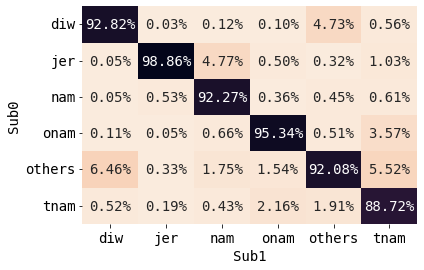

In [6]:
df3 = pd.DataFrame()
gandu0 = list(domains_of_created_block_centroids[0])
gandu1 = list(domains_of_created_block_centroids[1])

# Feature to display first N elemnts only on confusion matrix
N = 5
sub0_domains_not_needed, sub0_domain_counts = np.unique(gandu0, return_counts=True)
sub0_values = np.sort(np.asarray((sub0_domains_not_needed, sub0_domain_counts)).T)
count_sort_ind = np.argsort(-sub0_domain_counts)
sub0_domains_not_needed = list(sub0_domains_not_needed[count_sort_ind[N:]])

sub1_domains_not_needed, sub1_domain_counts = np.unique(gandu1, return_counts=True)
sub1_values = np.sort(np.asarray((sub1_domains_not_needed, sub1_domain_counts)).T)
count_sort_ind = np.argsort(-sub1_domain_counts)
sub1_domains_not_needed = list(sub1_domains_not_needed[count_sort_ind[N:]])

df3["sub0_edited"] = pd.Series(gandu0)
df3["sub0_edited"] = df3["sub0_edited"].replace(sub0_domains_not_needed, "others")
df3["sub1_edited"] = pd.Series(gandu1)
df3["sub1_edited"] = df3["sub1_edited"].replace(sub1_domains_not_needed, "others")


point_confusion_matrix_for_sub = pd.crosstab(
    df3["sub0_edited"], df3["sub1_edited"], rownames=["Sub0"], colnames=["Sub1"]
)
point_confusion_matrix_for_sub = pd.DataFrame(point_confusion_matrix_for_sub)

mt = cm.figure(0)
gn = sns.heatmap(
    (point_confusion_matrix_for_sub) / (np.sum(point_confusion_matrix_for_sub)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="rocket_r",
    cbar=False,
)

cm.show()

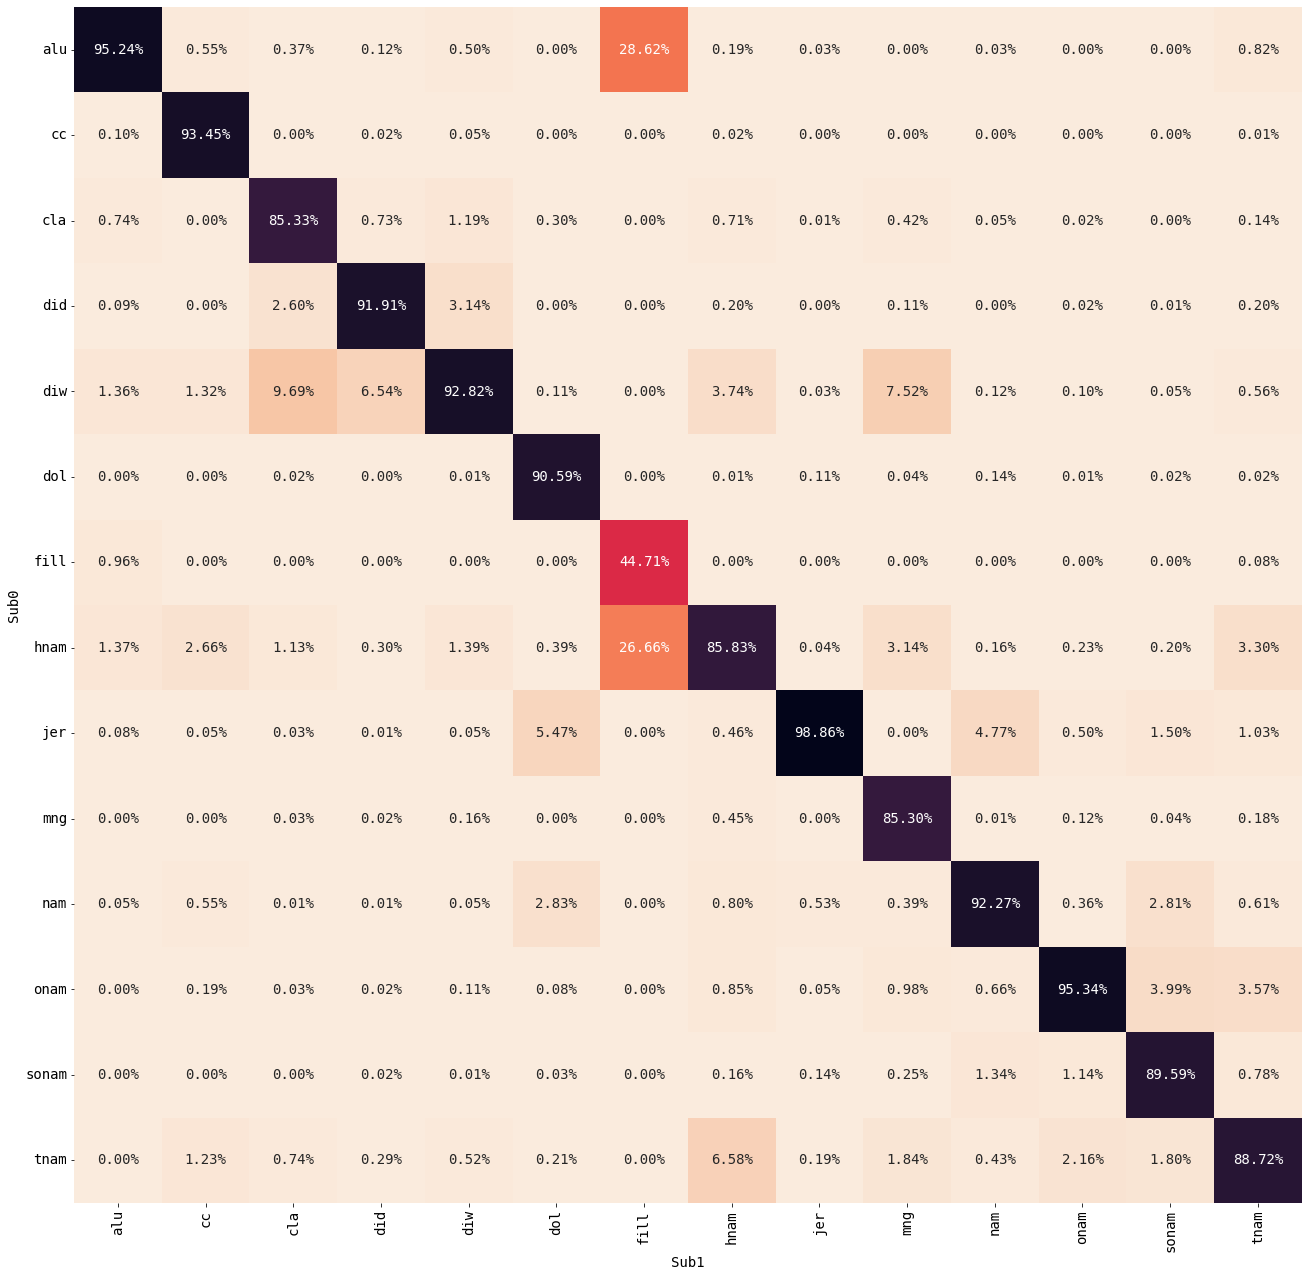

In [7]:
# CONFUSION MATRIX FOR SUB TO SUB COMPARISON

df3["sub0"] = pd.Series(gandu0)
df3["sub1"] = pd.Series(gandu1)

point_confusion_matrix_for_sub = pd.crosstab(
    df3["sub0"], df3["sub1"], rownames=["Sub0"], colnames=["Sub1"]
)
point_confusion_matrix_for_sub = pd.DataFrame(point_confusion_matrix_for_sub)

mt = cm.figure(0)
gn = sns.heatmap(
    (point_confusion_matrix_for_sub) / (np.sum(point_confusion_matrix_for_sub)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="rocket_r",
    cbar=False,
    xticklabels=True,
    yticklabels=True,
)

# cm.show()
mt.set_size_inches(22, 22)
mt.savefig("Entire_Matrix.png", dpi=100)
# Uncomment the lines below to generate a report.
# print(
#     metrics.classification_report(
#         df["Points Domain"], df["Block Domains"], labels=colour_names, zero_division=1
#     )
# # )

In [8]:
points_that_match = []
points_that_dont_match = []
for points_index, (x, y) in enumerate(zip(gandu0, gandu1)):
    if x == y:
        points_that_match.append(points_index)
    else:
        points_that_dont_match.append(points_index)


print(
    "Percenatge of space matching: "
    + str(100 * len(points_that_match) / len(gandu0))
    + " %"
)
print(
    "Percenatge of space not matching: "
    + str(100 * len(points_that_dont_match) / len(gandu0))
    + " %"
)

Percenatge of space matching: 93.93046734390143 %
Percenatge of space not matching: 6.069532656098574 %


In [9]:
print("Sub0:")
print(df3["sub0"].value_counts())


print(1 * "\n")
print("Sub1:")
print(df3["sub1"].value_counts())

Sub0:
jer      1295313
diw       447272
nam       445665
onam      341166
tnam      308041
alu       214865
hnam      195313
cla       164555
did       163656
sonam      64889
mng        34775
dol        15449
cc          4021
fill        3196
Name: sub0, dtype: int64


Sub1:
jer      1279624
nam       467798
diw       434390
onam      337060
tnam      312780
alu       218208
hnam      197459
cla       180631
did       156666
sonam      55935
mng        37527
dol        14510
cc          3649
fill        1939
Name: sub1, dtype: int64
